# Rotor Aeroacoustics Example

This notebook contains an example on how to run an aeroacoustic analysis using [FLOWUnsteady](https://flow.byu.edu/FLOWUnsteady/) coupled with PSU-WOPWOP. In here we show how to generate the aerodynamic solution, how to format the solution for PSU-WOPWOP (PSW, for short), run PSW to get tonal noise, use BPM to get broadband noise, and how the outputs can be visualized in Paraview and processed in a variety of forms.

We then compare results with experimental acoustic data from the literature.

Prior to running this notebook, you will need to add the PSU-WOPWOP binary `wopwop3_linux_serial` to your `FLOWUnsteady` folder, along with the experimental data that we will compare against (`zawodny-data/`). The folder should then look like this:


<img src="https://raw.githubusercontent.com/byuflowlab/FLOWUnsteady/master/docs/resources/colab/colab03.png" alt="Pic here" width="900px">


**NOTE 1:**  See [flow.byu.edu/FLOWUnsteady/tutorials/colab](https://flow.byu.edu/FLOWUnsteady/tutorials/aeroacoustics/) if you are missing any of these files.

**NOTE 2:**  PSU-WOPWOP is not included in the FLOWUnsteady suite, but the user can request a binary of PSU-WOPWOP directly from the developers at Penn State University.

## Mounting Google Drive

First, let's mount the Google Drive while we are still in the Python kernell. This will allow us to transfer files from this session and our Google Drive back and forth.

Upon running it, this cell will ask you to link your Google Drive. Please follow the instructions. Once successfully done, your drive will be mounted under `/content/drive` (you can check that it was successfully mounted under the `Files` tab on the right panel).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Mounting Julia Kernel

This cell installs Julia, associates PyCall with Python 2.7, installs the IJulia kernel for Jupyter, and mounts an image of all FLOW packages needed to run FLOWUnsteady. This process should take about 7 minutes.

In [ ]:
# Installation cell
%%shell
if ! command -v julia 3>&1 > /dev/null
then
    echo '********************** Downloading Julia *****************************'
    wget 'https://julialang-s3.julialang.org/bin/linux/x64/1.4/julia-1.4.2-linux-x86_64.tar.gz' \
        -O /tmp/julia.tar.gz
    tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
    rm /tmp/julia.tar.gz
fi
echo '********************** Setting up PyCall *********************************'
julia -e 'using Pkg; pkg"add PyCall;"; ENV["PYTHON"]="/usr/bin/python2"; pkg"build PyCall;"'

echo '********************** Setting up Julia Kernel on Jupyter ****************'
julia -e 'using Pkg; pkg"add IJulia;"'

echo '********************** Installing image of packages **********************'
tar -x --overwrite -f /content/drive/My\ Drive/FLOWUnsteady/dotjulia.tar.gz -C /root/.julia --strip-components 2

echo 'Done'

Now, let's activate the Julia kernel by going to Colab's `Edit` menu and select `Notebook settings` from the drop down. Select *Julia 1.4* as the runtime (set `Hardware accelerator` to `none` since we don't need GPU capabilities).

You should see something like this (with `Hardware accelerator` set to `none`):

<img src="https://raw.githubusercontent.com/byuflowlab/FLOWUnsteady/master/docs/resources/colab/colab00.png" alt="Pic here" width="400px">

Click on SAVE, and **we are ready to get going.**







Verify that the Julia kernel was successfully installed and is running:

In [ ]:
println("You know we are running Julia if this cell runs sucessfully")

Verify that PyCall was successfully set up with Python 2.7:

In [ ]:
import PyCall
PyCall.pyversion

# Single-rotor Noise &ndash; Example and Validation

In [ ]:
# Import all necessary packages
import CSV
using PyPlot

import FLOWUnsteady
import FLOWMath

# Aliases
uns = FLOWUnsteady
vlm = FLOWUnsteady.vlm
noise = FLOWUnsteady.noise
gt = FLOWUnsteady.gt
math = FLOWMath

# Path where to save simulation data
simdata_path = "/content/drive/My Drive/FLOWUnsteady/"

# Path to PSU-WOPWOP binary
psw_path = "/content/drive/My Drive/FLOWUnsteady/wopwop3_linux_serial"

## Test Case Description

The example shown here consists of an isolated 9.4in rotor in hover. The rotor and configuration matches the DJI 9443 propeller described in Zawodny, N. S., & Boyd, Jr., D. D., (2016), *Acoustic Characterization and Prediction of Representative, Small-scale Rotary-wing Unmanned Aircraft System Components*. See also the results shown in Alvarez, E. J., Schenk, A., Critchfield, T., and Ning, A., (2020), *Rotor-on-Rotor Aeroacoustic Interactions of Multirotor in Hover*.

This is what the actual DJI 9443 rotor looks like:

<img src="https://raw.githubusercontent.com/byuflowlab/FLOWUnsteady/master/examples/rotornoise/img/dji9443_00.png" alt="Pic here" width="300px">

This is the aeroacoustic output of FLOWUnsteady:

<img src="https://media.githubusercontent.com/media/byuflowlab/FLOWUnsteady/master/examples/rotornoise/vid/dji9443_ccblade01_1.gif" alt="Vid here" width="700px">

## *Step 1:* Aerodynamic Solution

In this step we use any of the aerodynamic solvers in FLOWUnsteady to generate the aerodynamic loading and rotor geometry. In this example we are using the quasi-steady solver that uses blade-element momentum theory (BEMT) to generate the aerodynamic solution shown below. The BEMT solution predicts a $C_T$ of 0.0734, meanwhile Zawodny et al. reports an experimental $C_T$ of 0.0719. This results in an **excellent agreement, with a discrepancy of only 2\% between FLOWUnsteady and the experimental $C_T$**.

This is what the aerodynamic solution looks like coming out of FLOWUnsteady:

<img src="https://media.githubusercontent.com/media/byuflowlab/FLOWUnsteady/master/examples/rotornoise/vid/dji9443_single_bemnoise_00_ww_1.gif" alt="Vid here" width="900px">

In [ ]:
save_path       = simdata_path*"dji9443_single_bemnoise_00/"  # Where to save the simulation


# ------------ PARAMETERS --------------------------------------------------
# Rotor geometry
rotor_file      = "DJI9443.csv"        # Rotor geometry
data_path       = uns.def_data_path    # Path to rotor database
pitch           = 0.0                  # (deg) collective pitch of blades
n               = 50                   # Number of blade elements
CW              = true                 # Clock-wise rotation
xfoil           = true                 # Whether to run XFOIL


# Read radius of this rotor and number of blades
R, B            = uns.read_rotor(rotor_file; data_path=data_path)[[1,3]]

# Simulation parameters
RPM             = 5400                 # RPM
J               = 0.0001               # Advance ratio Vinf/(nD)
rho             = 1.071778             # (kg/m^3) air density
mu              = 1.85508e-5           # (kg/ms) air dynamic viscosity
speedofsound    = 342.35               # (m/s) speed of sound
ReD             = 2*pi*RPM/60*R * rho/mu * 2*R   # Diameter-based Reynolds number

magVinf         = J*RPM/60*(2*R)
Vinf(X,t)       = magVinf*[1.0, 0, 0]  # (m/s) freestream velocity

# Aerodynamic solver
# VehicleType   = uns.UVLMVehicle      # Unsteady solver
VehicleType     = uns.QVLMVehicle      # Quasi-steady solver

# Solver parameters
const_solution  = true                 # Whether to use that the solution is constant or not
nrevs           = 10                   # Number of revolutions in simulation
nsteps_per_rev  = 120                  # Time steps per revolution
nsteps          = const_solution ? 2 : nrevs*nsteps_per_rev # Number of time steps
ttot            = nsteps*(RPM/60)/nsteps_per_rev            # (s) total simulation time

# (Unsteady solver parameters---not used in this example)
p_per_step      = 2                    # Sheds per time step
lambda          = 2.125                # Core overlap
overwrite_sigma = lambda * 2*pi*R/(nsteps_per_rev*p_per_step) # Smoothing core size
surf_sigma      = R/10                 # Smoothing radius of lifting surface
vlm_sigma       = surf_sigma           # Smoothing radius of VLM
shed_unsteady   = true                 # Shed particles from unsteady loading
                                       # Max particles for memory pre-allocation
max_particles   = ((2*n+1)*B)*nsteps*p_per_step

# OUTPUT OPTIONS
run_name        = "singlerotor"
nsteps_save     = 1                    # Save vtks every this many steps
save_wopwopin   = true                 # Generate inputs for PSU-WOPWOP
prompt          = false                # Whether to promp the user
verbose         = true
plot_disc       = true                 # Plot blade discretization for debugging




# ------------ SIMULATION SETUP --------------------------------------------
# Generate rotor
rotor = uns.generate_rotor(rotor_file; pitch=pitch,
                                        n=n, CW=CW, ReD=ReD, altReD=[RPM, J, mu/rho],
                                        verbose=verbose, xfoil=xfoil,
                                        data_path=data_path,
                                        plot_disc=plot_disc)

# ----- VEHICLE DEFINITION
# System of all FLOWVLM objects
system = vlm.WingSystem()
vlm.addwing(system, "Rotor1", rotor)

# Systems of rotors
rotors = vlm.Rotor[rotor]   # Defining this rotor as its own system
rotor_systems = (rotors,)

# Wake-shedding system (don't include the rotor if quasi-steady vehicle)
wake_system = vlm.WingSystem()

if VehicleType != uns.QVLMVehicle
    vlm.addwing(wake_system, "Rotor1", rotor)
else
    # Mute colinear warnings. This is needed since the quasi-steady solver
    #   will probe induced velocities at the lifting line of the blade
    uns.vlm.VLMSolver._mute_warning(true)
end

# Define vehicle object
vehicle = VehicleType(   system;
                            rotor_systems=rotor_systems,
                            wake_system=wake_system
                         )


# ----- MANEUVER DEFINITION
RPM_fun(t) = 1.0                # RPM (normalized by reference RPM) as a
                                # function of normalized time
angle = ()                      # Angle of each tilting system (none in this case)
sysRPM = (RPM_fun, )            # RPM of each rotor system
Vvehicle(t) = zeros(3)          # Translational velocity of vehicle over Vcruise
anglevehicle(t) = zeros(3)      # (deg) angle of the vehicle

# Define Maneuver object
maneuver = uns.KinematicManeuver(angle, sysRPM, Vvehicle, anglevehicle)

# Plot maneuver path and controls
uns.plot_maneuver(maneuver; vis_nsteps=nsteps)


# ----- SIMULATION DEFINITION
RPMref = RPM
Vref = 0.0

tinit = 0.0                                  # (s) initial time
Vinit = Vref*maneuver.Vvehicle(tinit/ttot)   # (m/s) initial vehicle velocity
angle1 = maneuver.anglevehicle(tinit/ttot)   # (rad/s) initial vehicle angular velocity
angle2 = maneuver.anglevehicle(tinit/ttot + 1e-12)
Winit = pi/180 * (angle2-angle1)/(ttot*1e-12)

simulation = uns.Simulation(vehicle, maneuver, Vref, RPMref, ttot;
                                            Vinit=Vinit, Winit=Winit, t=tinit)


# ----- MONITOR DEFINITION
monitor = uns.generate_monitor_rotors( rotors, J, rho, RPM, nsteps;
                                    t_scale=RPM/60,        # Time scaling factor for plots
                                    t_lbl="Revolutions",   # x-axis label
                                    # OUTPUT OPTIONS
                                    save_path=save_path,
                                    run_name="rotor",
                                    figname="monitor_rotor",
                                    disp_conv=verbose,)


# ------------ RUN SIMULATION ----------------------------------------------
pfield = uns.run_simulation(simulation, nsteps;
                                  # SIMULATION OPTIONS
                                  Vinf=Vinf,
                                  rho=rho,
                                  mu=mu,
                                  sound_spd=speedofsound,
                                  # SOLVERS OPTIONS
                                  p_per_step=p_per_step,
                                  overwrite_sigma=overwrite_sigma,
                                  vlm_sigma=vlm_sigma,
                                  surf_sigma=surf_sigma,
                                  max_particles=max_particles,
                                  shed_unsteady=shed_unsteady,
                                  extra_runtime_function=monitor,
                                  # OUTPUT OPTIONS
                                  save_path=save_path,
                                  run_name=run_name,
                                  nsteps_save=nsteps_save,
                                  save_wopwopin=save_wopwopin,
                                  prompt=prompt,
                                  verbose=verbose,
                             );     

## *Step 2:* Aeroacoustic Solution &ndash; Tonal Noise

In this step, we feed the aerodynamic solution to PSU-WOPWOP to obtain the tonal noise in a circular array of microphones located at 1.905 m from the rotor hub as shown below.

<img src="https://media.githubusercontent.com/media/byuflowlab/FLOWUnsteady/master/examples/rotornoise/vid/ransnoise_dji9443_single_new01_00_2.gif" alt="Vid here" width="500px">

In [ ]:
# Path from where to read aerodynamic solution
read_path       = simdata_path*"dji9443_single_bemnoise_00/"
# Path where to save PSU-WOPWOP's outputs
save_path       = simdata_path*"dji9443_single_bemnoise_00_psw00/"
# Path to PSU-WOPWOP binary (not included in FLOWUnsteady)
wopwopbin       = psw_path
# Run name (prefix of rotor files to read)
run_name        = "singlerotor"

# ------------ PARAMETERS --------------------------------------------------
# NOTE: Make sure that these parameters match what was used in the 
#       aerodynamic solution.

# Rotor geometry
rotor_file      = "DJI9443.csv"        # Rotor geometry
data_path       = uns.def_data_path    # Path to rotor database

# Read radius of this rotor and number of blades
R, B            = uns.read_rotor(rotor_file; data_path=data_path)[[1,3]]

rotorsystems    = [[B]]                # rotorsystems[si][ri] is the number of blades of the ri-th rotor in the si-th system

# Simulation parameters
RPM             = 5400                 # RPM is just a reference value to go from nrevs to simulation time
rho             = 1.071778             # (kg/m^3) air density
speedofsound    = 342.35               # (m/s) speed of sound

# Solver parameters
ww_nrevs        = 9                    # Number of revolutions in PSU-WOPWOP
ww_nsteps_per_rev = 120                # Number of steps per revolution in PSU-WOPWOP
num_min         = 1                    # Start reading aero files from this number
periodic        = true                 # Periodic aerodynamic solution
const_geometry  = true                 # Whether to run PSW on constant geometry from num_min
CW              = true                 # Clock-wise rotation of constant geometry

# Observer definition: Circular array of microphones
sph_R           = 1.905                # (m) radial distance from rotor hub
sph_nR          = 0
sph_nphi        = 0
sph_ntht        = 360                  # Number of microphones
sph_thtmin      = 0                    # (deg) first microphone's angle
sph_thtmax      = 360                  # (deg) last microphone's angle
sph_phimax      = 180
sph_rotation    = [90, 0, 0]           # Rotation of grid of microphones
obs_name = "circle_mic_array"          # Observer file name

# Observer definition: Single microphone
Rmic = 1.905                           # (m) radial distance from rotor hub
anglemic = 90*pi/180                   # (rad) microphone angle from plane of rotation (- below, + above)
                                       # 0deg is at the plane of rotation, 90deg is upstream
microphoneX = nothing                  # Comment and uncomment this to switch from array to single microphone
# microphoneX = Rmic*[-sin(anglemic), cos(anglemic), 0]


# ------------ RUN PSU-WOPWOP ----------------------------------------------
uns.run_noise_wopwop(read_path, run_name, RPM, rho, speedofsound, rotorsystems, 
                        ww_nrevs, ww_nsteps_per_rev, save_path, wopwopbin;
                        # ---------- OBSERVERS -------------------------
                        sph_R=sph_R,
                        sph_nR=sph_nR, sph_ntht=sph_ntht,
                        sph_nphi=sph_nphi, sph_phimax=sph_phimax,
                        sph_rotation=sph_rotation,
                        sph_thtmin=sph_thtmin, sph_thtmax=sph_thtmax,
                        microphoneX=microphoneX,
                        # ---------- SIMULATION OPTIONS ----------------
                        periodic=periodic,
                        # ---------- INPUT OPTIONS ---------------------
                        num_min=num_min,
                        const_geometry=const_geometry,
                        axisrot="automatic",
                        CW=CW,
                        # ---------- OUTPUT OPTIONS --------------------
                        verbose=true, v_lvl=0,
                        prompt=false, debug_paraview=false,
                        debuglvl=1,                     # WW debug level
                        observerf_name="observergrid",  # .xyz file with observer grid
                        case_name="runcase",            # Name of case to create and run
                        )

## *Optional Step:* Processing VTKs

When debugging things, I like to convert the PSU-WOPWOP's inputs back to vtk and visualize them in Paraview. This helps verify that we are passing the right things to PSU-WOPWOP. In order to do that, the following lines grab those inputs files that are formated for PSU-WOPWOP and converts them into vtk files.

In [ ]:
read_path = simdata_path*"dji9443_single_bemnoise_00_psw00/runcase/" # Path to PSW's input files
save_path = read_path*"../vtks/"                              # Where to save VTK files

# Create save path
noise.gt.create_path(save_path, true)

# Identify loft and compact PSW files
wopfiles = [fname for fname in readdir(read_path)
            if occursin("loft.wop", fname) || occursin("compact.wop", fname)]

vtk_str = "$save_path/"
            
for fname in wopfiles
    
    println("*"^73)
    println("*\t\tREADING $fname")
    println("*"^73)

    # Identifies loading file if compact patch
    if occursin("compact.wop", fname)
        lfname = fname[1:findfirst("compact.wop", fname)[1]-1]*"loading_constant.wop"
    else
        lfname = nothing
    end

    # Convert from PSW to VTK
    vtk_str *= noise.geomwopwop2vtk(fname; read_path=read_path,
                                loading_file=lfname, verbose=true,
                                save_path=save_path)[end]
end

println("Generated the following files:\n\t$(vtk_str)")

## *Step 3:* Aeroacoustic Solution &ndash; Broadband Noise

In [ ]:
# Path where to save BPM's outputs
save_path       = simdata_path*"dji9443_single_bemnoise_00_bpm00/"

# ------------ PARAMETERS --------------------------------------------------
# NOTE: Make sure that these parameters match what was used in the 
#       aerodynamic solution.

# Rotor geometry
rotor_file      = "DJI9443.csv"        # Rotor geometry
data_path       = uns.def_data_path    # Path to rotor database
pitch           = 0.0                  # (deg) collective pitch of blades
n               = 50                   # Number of blade elements
CW              = true                 # Clock-wise rotation


# Read radius of this rotor and number of blades
R, B            = uns.read_rotor(rotor_file; data_path=data_path)[[1,3]]

# Simulation parameters
RPM             = 5400                 # RPM
J               = 0.0001               # Advance ratio Vinf/(nD)
rho             = 1.071778             # (kg/m^3) air density
mu              = 1.85508e-5           # (kg/ms) air dynamic viscosity
speedofsound    = 342.35               # (m/s) speed of sound

magVinf         = J*RPM/60*(2*R)
Vinf(X,t)       = magVinf*[1.0, 0, 0]  # (m/s) freestream velocity

# BPM parameters
noise_correction= 0.65                 # Calibration parameter
TE_thickness    = 16.0                 # (deg) trailing edge thickness
freq_bins       = uns.BPM.default_f    # Frequency bins (default is one-third octave band)

# Observer definition: Circular array of microphones
sph_R           = 1.905                # (m) radial distance from rotor hub
sph_nR          = 0
sph_nphi        = 0
sph_ntht        = 360                  # Number of microphones
sph_thtmin      = 0                    # (deg) first microphone's angle
sph_thtmax      = 360                  # (deg) last microphone's angle
sph_phimax      = 180
sph_rotation    = [90, 0, 0]           # Rotation of grid of microphones

# Observer definition: Single microphone
Rmic = 1.905                           # (m) radial distance from rotor hub
anglemic = 90*pi/180                   # (rad) microphone angle from plane of rotation (- below, + above)
                                       # 0deg is at the plane of rotation, 90deg is upstream
microphoneX = nothing                  # Comment and uncomment this to switch from array to single microphone
# microphoneX = Rmic*[-sin(anglemic), cos(anglemic), 0]

# OUTPUT OPTIONS
prompt          = true                 # Whether to promp the user
verbose         = false
plot_disc       = false                # Plot blade discretization for debugging

# ------------ GENERATE GEOMETRY -------------------------------------------
# Generate rotor
rotor = uns.generate_rotor(rotor_file; pitch=pitch,
                                        n=n, CW=CW, ReD=0.0,
                                        verbose=verbose, xfoil=false,
                                        data_path=data_path,
                                        plot_disc=plot_disc)
rotors = vlm.Rotor[rotor]

# ------------ RUN BPM -----------------------------------------------------
uns.run_noise_bpm(rotors, RPM, Vinf, rho, mu, speedofsound,
                                save_path;
                                # ---------- OBSERVERS -------------------------
                                sph_R=sph_R,
                                sph_nR=sph_nR, sph_ntht=sph_ntht,
                                sph_nphi=sph_nphi, sph_phimax=sph_phimax,
                                sph_rotation=sph_rotation,
                                sph_thtmin=sph_thtmin, sph_thtmax=sph_thtmax,
                                microphoneX=microphoneX,
                                # ---------- BPM OPTIONS -----------------------
                                noise_correction=noise_correction,
                                TE_thickness=TE_thickness,
                                freq_bins=freq_bins,
                                # ---------- OUTPUT OPTIONS --------------------
                                prompt=prompt
                                );

## *Step 4:* Processing and Plotting Results

In this section we process the data to add the tonal and broadband together, and plot the results.

### Read Data

In this cell we read both the tonal and broadband noise solutions that we have previously generated:

In [ ]:
# Dataset to read and associated information
dataset_infos = [   # (label, PSW solution, BPM solution, BPM freq bins, line style, color)
                    ("FLOWUnsteady w/BEMT", simdata_path*"dji9443_single_bemnoise_00_psw00/runcase/", 
                             simdata_path*"dji9443_single_bemnoise_00_bpm00/", uns.BPM.default_f, "-", "r")
                ];

datasets_psw = Dict()     # Stores PSW data in this dictionary
datasets_bpm = Dict()     # Stores BPM data in this dictionary

# Fields to read
psw_fieldnames = ["pressure", "spl_spectrum", "OASPLdB", "OASPLdBA"]
bpm_fieldnames = ["spl_spectrum", "splA_spectrum", "OASPLdB", "OASPLdBA"]

# Read each dataset
for (lbl, psw_read_path, bpm_read_path) in dataset_infos
    
    datasets_psw[lbl] = noise.fetch_pswdataset(psw_read_path; fieldnames=psw_fieldnames)
    datasets_bpm[lbl] = noise.fetch_bpmdataset(bpm_read_path; fieldnames=bpm_fieldnames)
    
end

In [ ]:
# Make sure this grid is the same used as an observer by the aeroacoustic solution
sph_R = 1.905                    # (m) radial distance from rotor hub
sph_nR = 0
sph_nphi = 0
sph_ntht = 360                   # Number of microphones
sph_thtmin = 0                   # (deg) first microphone's angle
sph_thtmax = 360                 # (deg) last microphone's angle
sph_phimax = 180
sph_rotation = [90, 0, 0]        # Rotation of grid of microphones

# Create observer grid
grid = noise.observer_sphere(sph_R, sph_nR, sph_ntht, sph_nphi; 
                                thtmin=sph_thtmin, thtmax=sph_thtmax, phimax=sph_phimax,
                                rotation=sph_rotation);

# This function calculates the angle that corresponds to every microphone
pangle(i) = -180/pi*atan(gt.get_node(grid, i)[1], gt.get_node(grid, i)[2])

### Pressure Waveform

In here we plot the pressure waveform at some of the microphones. **This pressure waveform includes only the tonal component**, as given by PSU-WOPWOP.

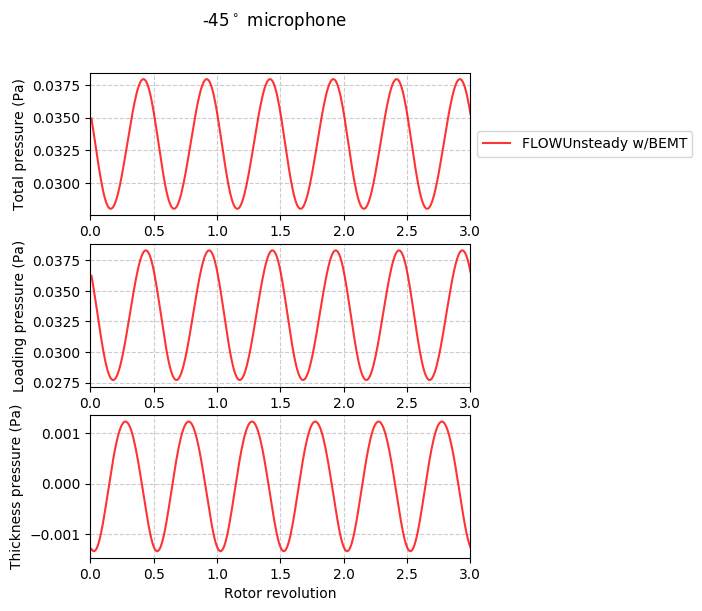

In [26]:
#@title .
microphones  = [-45]                 # (deg) microphones to plot
RPM          = 5400                  # RPM of solution

fieldname = "pressure"               # Field to plot
mics         = -microphones .+ 181   # Index of every microphone

for mici in mics

    figure(figsize=[7*1, 3*3]*0.7)
    suptitle("$(Int(round(pangle(mici))))"*L"$^\circ$ microphone")
    
    for (ploti, (ylbl, dlbl)) in enumerate([
                                            ("Total pressure (Pa)", "TotalAcousticPressure"),
                                            ("Loading pressure (Pa)", "LoadingAcousticPressure"),
                                            ("Thickness pressure (Pa)", "ThicknessAcousticPressure"),
                                          ])
        subplot(310+ploti) 
        if ploti==3; xlabel("Rotor revolution"); end;
        xlim([0, 3])
        ylabel(ylbl)
        PyPlot.grid(true, which="major", color="0.8", linestyle="--")
        PyPlot.grid(true, which="minor", color="0.8", linestyle="--")


        for (di, (lbl, read_path, _, _, stl, clr)) in enumerate(dataset_infos)

            data = datasets_psw[lbl][fieldname]
            xi = data["hs"]["ObserverTimes"]
            yi = data["hs"][dlbl]

            plot(data["field"][mici, 1, 2:end, xi]*(RPM/60),
                data["field"][mici, 1, 2:end, yi],  stl, alpha=0.8, label=lbl, color=clr)

        end

        if ploti==1; legend(loc="center left", bbox_to_anchor=(1, 0.5)); end;
    end
    
end

### SPL Spectrum

Here we compare the SPL spectrum at the microphone $-45^\circ$ below the plane of rotation with the experimental data reported by Zawodny, N. S., & Boyd, Jr., D. D., (2016), *Acoustic Characterization and Prediction of Representative, Small-scale Rotary-wing Unmanned Aircraft System Components*.

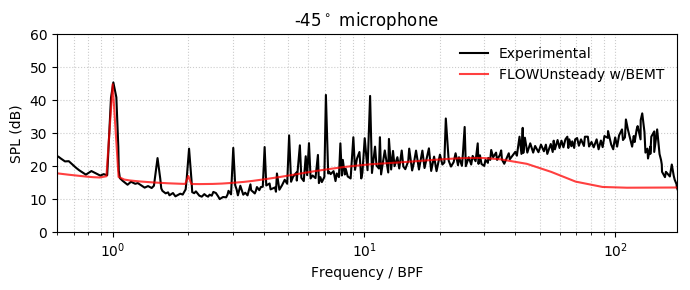

┌ Warning: `CSV.read(input; kw...)` is deprecated in favor of `DataFrame!(CSV.File(input; kw...))`
└ @ CSV /root/.julia/packages/CSV/W9RT2/src/CSV.jl:40


In [16]:
#@title .
microphone   = -45                   # (deg) microphone to plot
RPM          = 5400                  # RPM of solution
BPF          = 2*RPM/60              # Blade passing frequency

fieldname    = "spl_spectrum"        # Field to plot
mici         = -microphone .+ 181    # Index of each microphone


figure(figsize=[7, 3])

# Plot experimental data from Zawodny et al., Fig. 9
data = CSV.read("/content/drive/My Drive/FLOWUnsteady/zawodny-data/zawodny_dji9443_spl_5400_01.csv")
plot(data[!, 1]/BPF, data[!, 2], "-", label="Experimental", color="k")

# Plot datasets
for (lbl, _, _, freq_bins_bpm, stl, clr) in dataset_infos

    # Fetch tonal noise
    data_psw = datasets_psw[lbl][fieldname]
    xi = data_psw["hs"]["Frequency"]
    yi = data_psw["hs"]["Total_dB"]
    freqs_psw = data_psw["field"][mici, 1, 2:end, xi]
    spl_psw = data_psw["field"][mici, 1, 2:end, yi]
    
    # Fetch broadband noise
    data_bpm = datasets_bpm[lbl][fieldname]
    org_spl_bpm = data_bpm["field"][:, mici]
    
    # Define the range of frequency as the union of both components
    freqs = freqs_psw                       # Grab PSW frequency range
    if freqs_psw[end] < freq_bins_bpm[end]  # Add BPM range
        bpm_i = findfirst( f -> f > freqs_psw[end], freq_bins_bpm)
        freqs = vcat(freqs, freq_bins_bpm[bpm_i:end])
        spl_psw = vcat(spl_psw, [-30.0 for i in bpm_i:length(freq_bins_bpm)])
    end
    
    # Interpolate broadband data into the same frequencies than tonal data
    spl_bpm = math.akima(freq_bins_bpm, org_spl_bpm, freqs)
    
    # Add tonal and broadband SPL together
    spl = noise.addSPL(spl_psw, spl_bpm)

    plot(freqs/BPF, spl,  stl, alpha=0.75, label=lbl, color=clr)

end

title("$(Int(round(pangle(mici))))"*L"$^\circ$ microphone")
xlim([6*10.0^(-1.0), 1.75e2])
xscale("log")
xlabel("Frequency / BPF")
ylim([0, 60])
ylabel("SPL (dB)")
PyPlot.grid(true, which="major", color="0.8", linestyle=":")
PyPlot.grid(true, which="minor", color="0.8", linestyle=":")
legend(loc="best", frameon=false)

tight_layout()

### A-weighted SPL Spectrum

Same than previous plot, but A-weighted.

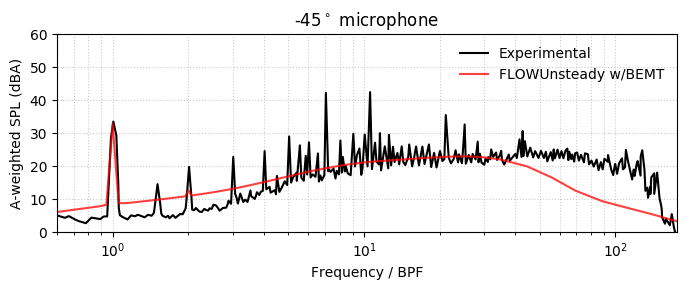

┌ Warning: `CSV.read(input; kw...)` is deprecated in favor of `DataFrame!(CSV.File(input; kw...))`
└ @ CSV /root/.julia/packages/CSV/W9RT2/src/CSV.jl:40


In [20]:
#@title .
microphone   = -45                   # (deg) microphone to plot
RPM          = 5400                  # RPM of solution
BPF          = 2*RPM/60              # Blade passing frequency

fieldname    = "spl_spectrum"        # Field to plot
mici         = -microphone .+ 181   # Index of every microphone


figure(figsize=[7, 3])

# Plot experimental data from Zawodny et al., Fig. 9
data = CSV.read("/content/drive/My Drive/FLOWUnsteady/zawodny-data/zawodny_dji9443_spl_5400_01.csv")
splA_exp = noise.aWeight.(data[!, 1], data[!, 2])
plot(data[!, 1]/BPF, splA_exp, "-", label="Experimental", color="k")

# Plot datasets
for (lbl, _, _, freq_bins_bpm, stl, clr) in dataset_infos

    # Fetch tonal noise
    data_psw = datasets_psw[lbl][fieldname]
    xi = data_psw["hs"]["Frequency"]
    yi = data_psw["hs"]["Total_dBA"]
    freqs_psw = data_psw["field"][mici, 1, 2:end, xi]
    spl_psw = data_psw["field"][mici, 1, 2:end, yi]
    
    # Fetch broadband noise
    data_bpm = datasets_bpm[lbl]["splA_spectrum"]
    org_spl_bpm = data_bpm["field"][:, mici]
    
    # Define the range of frequency as the union of both components
    freqs = freqs_psw                       # Grab PSW frequency range
    if freqs_psw[end] < freq_bins_bpm[end]  # Add BPM range
        bpm_i = findfirst( f -> f > freqs_psw[end], freq_bins_bpm)
        freqs = vcat(freqs, freq_bins_bpm[bpm_i:end])
        spl_psw = vcat(spl_psw, [-30.0 for i in bpm_i:length(freq_bins_bpm)])
    end
    
    # Interpolate broadband data into the same frequencies than tonal data
    spl_bpm = math.akima(freq_bins_bpm, org_spl_bpm, freqs)
    
    # Add tonal and broadband SPL together
    spl = noise.addSPL(spl_psw, spl_bpm)

    plot(freqs/BPF, spl,  stl, alpha=0.75, label=lbl, color=clr)

end

title("$(Int(round(pangle(mici))))"*L"$^\circ$ microphone")
xlim([6*10.0^(-1.0), 1.75e2])
xscale("log")
xlabel("Frequency / BPF")
ylim([0, 60])
ylabel("A-weighted SPL (dBA)")
PyPlot.grid(true, which="major", color="0.8", linestyle=":")
PyPlot.grid(true, which="minor", color="0.8", linestyle=":")
legend(loc="best", frameon=false)

tight_layout()

### Tonal Directivity &ndash; First BPF

Here we plot SPL of the first blade-passing frequency and compare it both with the experimental measurements, and prediction by OVERFLOW2 and a BEMT with ANOPP.

┌ Warning: `CSV.read(input; kw...)` is deprecated in favor of `DataFrame!(CSV.File(input; kw...))`
└ @ CSV /root/.julia/packages/CSV/W9RT2/src/CSV.jl:40
┌ Warning: `CSV.read(input; kw...)` is deprecated in favor of `DataFrame!(CSV.File(input; kw...))`
└ @ CSV /root/.julia/packages/CSV/W9RT2/src/CSV.jl:40


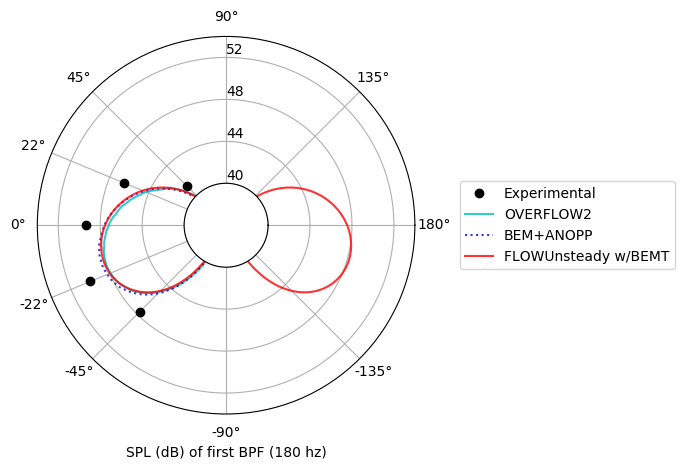

┌ Warning: `CSV.read(input; kw...)` is deprecated in favor of `DataFrame!(CSV.File(input; kw...))`
└ @ CSV /root/.julia/packages/CSV/W9RT2/src/CSV.jl:40


In [21]:
#@title .
BPFi         = 1                     # BPF multiple to plot
RPM          = 5400                  # RPM of solution
BPF          = 2*RPM/60              # Blade passing frequency

fieldname    = "spl_spectrum"        # Field to plot

# Plot experimental and computational data reported by Zawodny et al., Fig. 14
data_exp = CSV.read("/content/drive/My Drive/FLOWUnsteady/zawodny-data/zawodny_fig14_topright_exp00.csv", datarow=1)
data_of = CSV.read("/content/drive/My Drive/FLOWUnsteady/zawodny-data/zawodny_fig14_topright_of00.csv", datarow=1)
data_pas = CSV.read("/content/drive/My Drive/FLOWUnsteady/zawodny-data/zawodny_fig14_topright_pas00.csv", datarow=1)

polar(pi/180*data_exp[!, 2], data_exp[!, 1], "o", label="Experimental", color="k")
polar(pi/180*data_of[!, 2], data_of[!, 1], "-", label="OVERFLOW2", alpha=0.8, color="c")
polar(pi/180*data_pas[!, 2], data_pas[!, 1], ":b", label="BEM+ANOPP", alpha=0.8)

# Grab angles
pointangles = pangle.(1:grid.nnodes)

# Plot datasets
for (lbl, _, _, freq_bins_bpm, stl, clr) in dataset_infos

    # Fetch tonal noise
    data_psw = datasets_psw[lbl][fieldname]
    yi = data_psw["hs"]["Total_dB"]
    fi = data_psw["hs"]["Frequency"]
    
    df = data_psw["field"][1, 1, 2, fi] - data_psw["field"][1, 1, 1, fi] # Frequency step
    freqi = ceil(Int, BPFi*BPF/df + 1)                           # Frequency index
    freq = data_psw["field"][1, 1, freqi, fi]                    # Frequency
    # _lbl = " @ $(data_psw["field"][1, 1, freqi, fi]) Hz"         # Frequency string
    _lbl = ""
    
    spl_psw = data_psw["field"][:, 1, freqi, yi]
    
    # Fetch broadband noise
    data_bpm = datasets_bpm[lbl][fieldname]
    spl_bpm = [math.akima(freq_bins_bpm, data_bpm["field"][:, mici], freq) for mici in 1:grid.nnodes]
    
    # Add tonal and broadband SPL together
    spl = noise.addSPL(spl_psw, spl_bpm)
    
    
    polar(pi/180*pointangles, spl, stl, label=lbl*_lbl, alpha=0.8, color=clr)
end

ax = gca()
ax.set_theta_zero_location("W")
ax.set_theta_direction(-1)
ax.set_thetalim(pi/180*180*[1, -1])
ax.set_rlabel_position(90)
ax.set_rticks(40:4:52)
ax.set_rlim([40, 54])
ax.set_rorigin(36)
ax.set_thetagrids(collect(-180:45/2:180)[[3, 5, 7, 8, 9, 10, 11, 13, 15, 17]])
ax.grid(true)
xlabel("SPL (dB) of first BPF ($(ceil(Int, BPFi*BPF)) hz)")
legend(loc="center left", bbox_to_anchor=(1.1, 0.5))
tight_layout();

### Overall SPL Directivity

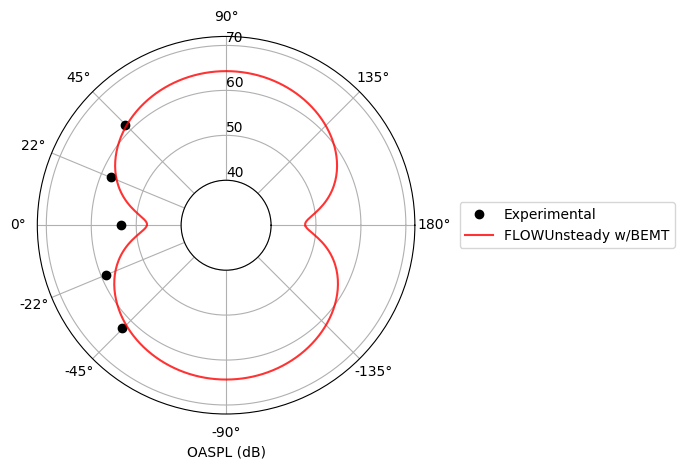

┌ Warning: `CSV.read(input; kw...)` is deprecated in favor of `DataFrame!(CSV.File(input; kw...))`
└ @ CSV /root/.julia/packages/CSV/W9RT2/src/CSV.jl:40


In [23]:
#@title .
fieldname    = "OASPLdB"        # Field to plot

# Plot experimental data reported by Zawodny et al., Fig. 12
data_exp = CSV.read("/content/drive/My Drive/FLOWUnsteady/zawodny-data/zawodny_fig12_left_5400_00.csv", datarow=1)
polar(pi/180*data_exp[!, 2], data_exp[!, 1], "ok", label="Experimental")

# Grab angles
pointangles = pangle.(1:grid.nnodes)

# Plot datasets
for (lbl, _, _, freq_bins_bpm, stl, clr) in dataset_infos

    # Fetch tonal noise
    data_psw = datasets_psw[lbl][fieldname]
    yi = data_psw["hs"]["TotalOASPLdB"]
    oaspl_psw = data_psw["field"][:, 1, 1, yi]
    
    # Fetch broadband noise
    data_bpm = datasets_bpm[lbl][fieldname]
    oaspl_bpm = data_bpm["field"][:]
    
    # Add tonal and broadband OASPL together
    oaspl = noise.addSPL(oaspl_psw, oaspl_bpm)
    
    polar(pi/180*pointangles, oaspl, stl, label=lbl, alpha=0.8, color=clr)
end

ax = gca()
ax.set_theta_zero_location("W")
ax.set_theta_direction(-1)
ax.set_thetalim(pi/180*180*[1, -1])
ax.set_rlabel_position(90)
ax.set_rticks(40:10:70)
ax.set_rlim([40, 72])
ax.set_rorigin(30)
ax.set_thetagrids(collect(-180:45/2:180)[[3, 5, 7, 8, 9, 10, 11, 13, 15, 17]])
ax.grid(true)
xlabel("OASPL (dB)")
legend(loc="center left", bbox_to_anchor=(1.1, 0.5))
tight_layout();

### A-weighted Overall SPL Directivity

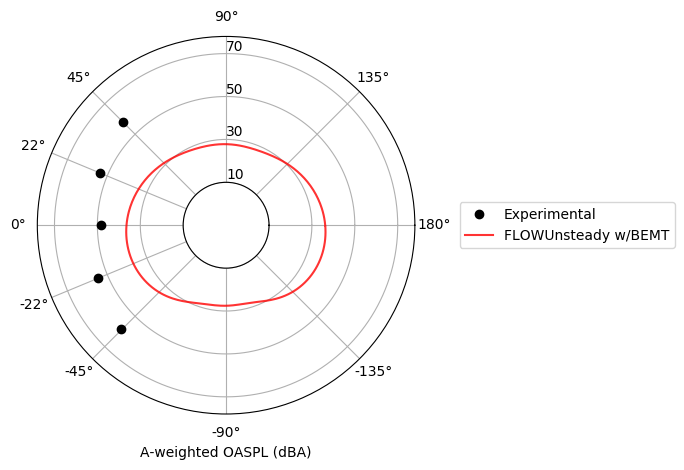

┌ Warning: `CSV.read(input; kw...)` is deprecated in favor of `DataFrame!(CSV.File(input; kw...))`
└ @ CSV /root/.julia/packages/CSV/W9RT2/src/CSV.jl:40


In [24]:
#@title .
fieldname    = "OASPLdBA"        # Field to plot

# Plot experimental data reported by Zawodny et al., Fig. 12
data_exp = CSV.read("/content/drive/My Drive/FLOWUnsteady/zawodny-data/zawodny_fig12_right_5400_00.csv", datarow=1)
polar(pi/180*data_exp[!, 2], data_exp[!, 1], "ok", label="Experimental")

# Grab angles
pointangles = pangle.(1:grid.nnodes)

# Plot datasets
for (lbl, _, _, freq_bins_bpm, stl, clr) in dataset_infos

    # Fetch tonal noise
    data_psw = datasets_psw[lbl][fieldname]
    yi = data_psw["hs"]["TotalA-weightedSPLdBA"]
    oaspl_psw = data_psw["field"][:, 1, 1, yi]
    
    # Fetch broadband noise
    data_bpm = datasets_bpm[lbl][fieldname]
    oaspl_bpm = data_bpm["field"][:]
    
    # Add tonal and broadband OASPL together
    oaspl = noise.addSPL(oaspl_psw, oaspl_bpm)
    
    polar(pi/180*pointangles, oaspl, stl, label=lbl, alpha=0.8, color=clr)
end

ax = gca()
ax.set_theta_zero_location("W")
ax.set_theta_direction(-1)
ax.set_thetalim(pi/180*180*[1, -1])
ax.set_rlabel_position(90)
ax.set_rticks(10:20:70)
ax.set_rlim([10, 78])
ax.set_rorigin(-10)
ax.set_thetagrids(collect(-180:45/2:180)[[3, 5, 7, 8, 9, 10, 11, 13, 15, 17]])
ax.grid(true)
xlabel("A-weighted OASPL (dBA)")
legend(loc="center left", bbox_to_anchor=(1.1, 0.5))
tight_layout();